## Home Work 4   Decision Trees and Random Forests

### Motivating Random Forests: Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

![](figures/05.08-decision-tree.png)


The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

In [66]:
# imports
from sklearn import cross_validation, datasets, linear_model, metrics, model_selection
from sklearn.utils import shuffle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

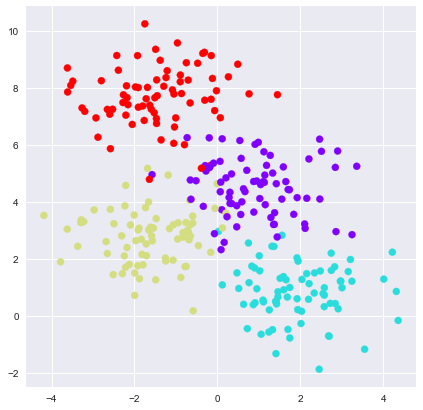

In [45]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
This figure presents a visualization of the first four levels of a decision tree classifier for this data:

![](figures/05.08-decision-tree-levels.png)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [41]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a quick utility function to help us visualize the output of the classifier:

In [51]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


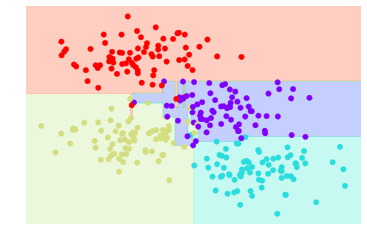

In [52]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

### Decision trees and over-fitting

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

![](figures/05.08-decision-tree-overfitting.png)

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


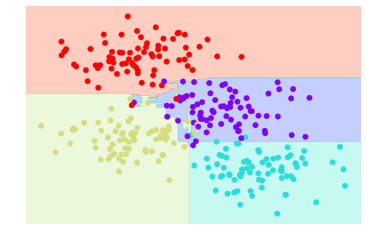

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


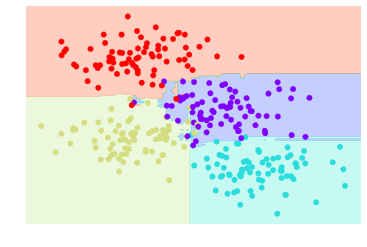

In [54]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

###  Introducing Scikit-Learn

There are several Python libraries which provide solid implementations of a range of machine learning algorithms.
One of the best known is [Scikit-Learn](http://scikit-learn.org), a package that provides efficient versions of a large number of common algorithms.
Scikit-Learn is characterized by a clean, uniform, and streamlined API, as well as by very useful and complete online documentation.
A benefit of this uniformity is that once you understand the basic use and syntax of Scikit-Learn for one type of model, switching to a new model or algorithm is very straightforward.

#### Data Representation in Scikit-Learn

Machine learning is about creating models from data: for that reason, we'll start by discussing how data can be represented in order to be understood by the computer. The best way to think about data within Scikit-Learn is in terms of tables of data. A basic table is a two-dimensional grid of data, in which the rows represent individual elements of the dataset, and the columns represent quantities related to each of these elements.

#### Features matrix

This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, which we will call the *features matrix*.
By convention, this features matrix is often stored in a variable named ``X``.
The features matrix is assumed to be two-dimensional, with shape ``[n_samples, n_features]``, and is most often contained in a NumPy array or a Pandas ``DataFrame``, though some Scikit-Learn models also accept SciPy sparse matrices.

The samples (i.e., rows) always refer to the individual objects described by the dataset.
For example, the sample might be a flower, a person, a document, an image, a sound file, a video, an astronomical object, or anything else you can describe with a set of quantitative measurements.

The features (i.e., columns) always refer to the distinct observations that describe each sample in a quantitative manner.
Features are generally real-valued, but may be Boolean or discrete-valued in some cases.

#### Target array

In addition to the feature matrix ``X``, we also generally work with a *label* or *target* array, which by convention we will usually call ``y``.
The target array is usually one dimensional, with length ``n_samples``, and is generally contained in a NumPy array or Pandas ``Series``.
The target array may have continuous numerical values, or discrete classes/labels.
While some Scikit-Learn estimators do handle multiple target values in the form of a two-dimensional, ``[n_samples, n_targets]`` target array, we will primarily be working with the common case of a one-dimensional target array.

To summarize, the expected layout of features and target values is visualized in the following diagram:

![](figures/05.02-samples-features.png)

#### Scikit-Learn's Estimator API

The Scikit-Learn API is designed with the following guiding principles in mind, as outlined in the [Scikit-Learn API paper](http://arxiv.org/abs/1309.0238):

- *Consistency*: All objects share a common interface drawn from a limited set of methods, with consistent documentation.

- *Inspection*: All specified parameter values are exposed as public attributes.

- *Limited object hierarchy*: Only algorithms are represented by Python classes; datasets are represented
  in standard formats (NumPy arrays, Pandas ``DataFrame``s, SciPy sparse matrices) and parameter
  names use standard Python strings.

- *Composition*: Many machine learning tasks can be expressed as sequences of more fundamental algorithms,
  and Scikit-Learn makes use of this wherever possible.

- *Sensible defaults*: When models require user-specified parameters, the library defines an appropriate default value.

In practice, these principles make Scikit-Learn very easy to use, once the basic principles are understood.
Every machine learning algorithm in Scikit-Learn is implemented via the Estimator API, which provides a consistent interface for a wide range of machine learning applications.

### Basics of the API

Most commonly, the steps in using the Scikit-Learn estimator API are as follows.

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

# Home Work 4

## Application: Exploring Hand-written Digits

 let's consider one piece of the optical character recognition problem: the identification of hand-written digits. In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use Scikit-Learn's set of pre-formatted digits, which is built into the library.

#### Loading and visualizing the digits data

We'll use Scikit-Learn's data access interface and take a look at this data:

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

In [14]:
#let's look at the structure of our dataset. Let's show the keys
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [10]:
#Let's read the description
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [16]:
# Let's look at the target and shape
# We have 1,797 samples each corresponds to one of the pictures Hand-written Digits
print(digits.target)
print(digits.target.shape)

[0 1 2 ... 8 9 8]
(1797,)


In [15]:
# Let's look at the data and shape
# We have 1,797 samples each consisting of an 8 × 8 (an 2D array of 64 values)
# These data are obtained from real pictures Hand-written Digits (from digits.images)
# Each pictures (8 × 8) Hand-written Digits (from digits.images) was transformed into a 1D array
# - a string of 64 values. So it is more convenient to traine the model
print(digits.data)
print(digits.data.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
(1797, 64)


Let's visualize our data
The images data is a three-dimensional array: 1,797 samples each consisting of an 8 × 8 grid of pixels.
Let's visualize the first hundred of these:

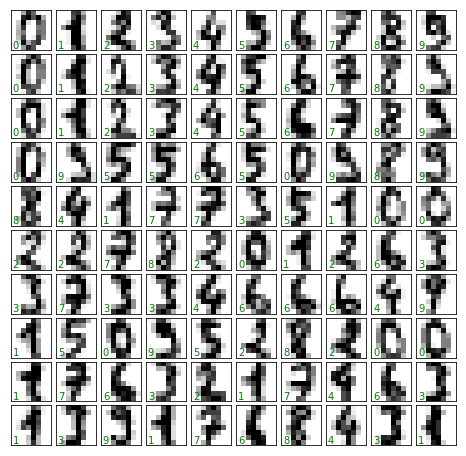

In [6]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, [n_samples, n_features] representation. We can accomplish this by treating each pixel in the image as a feature: that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit. Additionally, we need the target array, which gives the previously determined label for each digit. These two quantities are built into the digits dataset under the data and target attributes, respectively:

### Unsupervised learning: Dimensionality reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to effectively visualize points in such a high-dimensional space.
Instead we'll reduce the dimensions to 2, using an unsupervised method.
Here, we'll make use of a manifold learning algorithm called *Isomap*  and transform the data to two dimensions:

In [18]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

We see that the projected data is now two-dimensional.
Let's plot this data to see if we can learn anything from its structure:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


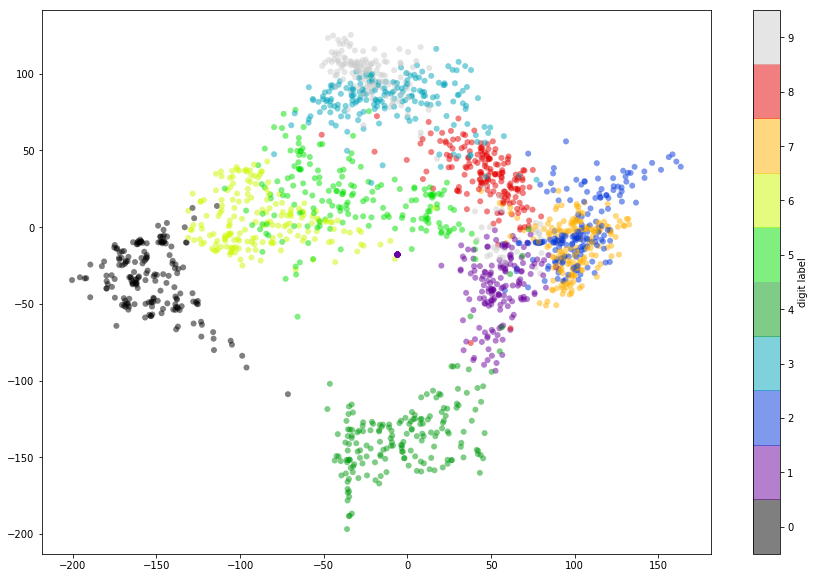

In [21]:
plt.figure(figsize=(15,10))
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

This plot gives us some good intuition into how well various numbers are separated in the larger 64-dimensional space. For example, zeros (in black) and ones (in purple) have very little overlap in parameter space.
Intuitively, this makes sense: a zero is empty in the middle of the image, while a one will generally have ink in the middle.
On the other hand, there seems to be a more or less continuous spectrum between ones and fours: we can understand this by realizing that some people draw ones with "hats" on them, which cause them to look similar to fours.

Overall, however, the different groups appear to be fairly well separated in the parameter space: this tells us that even a very straightforward supervised classification algorithm should perform suitably on this data.
Let's give it a try.

### Classification on digits

Let's apply a classification algorithm to the digits.
 we will split the data into a training and testing set, and fit a Gaussian naive Bayes model:

We see here that there are 1,797 samples and 64 features.

In [69]:
X = digits.data
X.shape

(1797, 64)

In [70]:
y = digits.target
y.shape

(1797,)

In [71]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, random_state=0)

In [72]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain, ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest)             # 4. predict on new data

Now that we have predicted our model, we can gauge its accuracy by comparing the true values of the test set to the predictions:

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

With even this extremely simple model, we find about 80% accuracy for classification of the digits!
However, this single number doesn't tell us *where* we've gone wrong—one nice way to do this is to use the *confusion matrix*, which we can compute with Scikit-Learn and plot with Seaborn:

We can take a look at the classification report for this classifier:

In [89]:
print(metrics.classification_report(ytest, y_model))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.70      0.91      0.79        43
          2       0.95      0.45      0.62        44
          3       0.83      0.87      0.85        45
          4       0.94      0.82      0.87        38
          5       0.98      0.90      0.93        48
          6       1.00      0.98      0.99        52
          7       0.76      0.98      0.85        48
          8       0.55      0.79      0.65        48
          9       1.00      0.64      0.78        47

avg / total       0.87      0.83      0.83       450



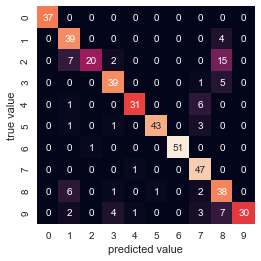

In [74]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False )
plt.xlabel('predicted value')
plt.ylabel('true value');

This shows us where the mis-labeled points tend to be: for example, a large number of twos here are mis-classified as either ones or eights.
Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels.
We'll use green for correct labels, and red for incorrect labels:

## Task 1

In [ ]:
#  divide the original dataset into learning and test samples.
# train_data, test_data, train_labels, test_labels=model_selection.train_test_split(..,..,test_size=0.3, random_state=1)
#Your code here


Using RidgeClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), build, fit and predict a model.

In [90]:
#Your code here


Now that we have predicted our model, we can gauge its accuracy by comparing the true values of the test set to the predictions. If you do not know what is an accuracy_score please read: https://developers.google.com/machine-learning/crash-course/classification/accuracy

In [ ]:
# Do an assessment of the quality of the classification
# Use the metrics.accuracy_score( ...)
# Your code here


If you do not know what is precision    recall  f1-score   support. Please read: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall and https://github.com/SerhiyProtsenko/LublinDataScienceWorkshop/blob/master/lectures/3.0%20-%20Evaluating%20models.%20Validation.%20Metrics.ipynb

In [ ]:
# take a look at the classification report for this classifier
# metrics.classification_report(.....)
# Your code here


Describe the result. What Values Mean? What pictures does our model recognize badly?

In [92]:
# Your answers are here
#1.
#2.
#3.
#....

In [ ]:
# take a look at the confusion_matrix for this classifier
# Use the code above
# Your code here


Describe the result. What Values Mean? What pictures does our model recognize badly?

In [91]:
# Your answers are here
#1.
#2.
#3.
#....

## Task 2

Repeat all that is done in __Task 1__ for the model LogisticRegression.
Compare the results of models

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [ ]:
# Your code here


## Task 3

In [94]:
from sklearn.tree import DecisionTreeClassifier

Repeat all that is done in __Task 1__ for the model DecisionTreeClassifier.
Compare the results of models

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [ ]:
# Your code here


## Task 4

In [95]:
from sklearn.ensemble import BaggingClassifier

Repeat all that is done in __Task 1__ for the model BaggingClassifier with DecisionTreeClassifier.
Compare the results of models

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier

In [96]:
# Your code here


## Task 5

In [97]:
from sklearn.ensemble import RandomForestClassifier

Repeat all that is done in __Task 1__ for the model RandomForestClassifier.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [99]:
# Your code here
